In [1]:
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch 
import os
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from sklearn.model_selection import train_test_split
import shap


%matplotlib inline
%config InlineBackend.figure_format='retina'
 
sns.set(style='whitegrid', palette='muted', font_scale=1.2) 
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"] 
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE)) 
rcParams['figure.figsize'] = 14, 6
register_matplotlib_converters()
 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
pd.read_csv(f'../data/testset.csv')

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100985,20170424-06:00,Haze,17.0,0,0,NaN,25.0,NaN,1005.0,0,0,34.0,0,0,4.0,320.0,NW,NaN,NaN,11.1
100986,20170424-09:00,Haze,14.0,0,0,NaN,16.0,NaN,1003.0,0,0,38.0,0,0,4.0,320.0,NW,NaN,NaN,22.2
100987,20170424-12:00,Haze,12.0,0,0,NaN,14.0,NaN,1002.0,0,0,36.0,0,0,4.0,270.0,West,NaN,NaN,18.5
100988,20170424-15:00,Haze,15.0,0,0,NaN,27.0,NaN,1004.0,0,0,32.0,0,0,2.0,320.0,NW,NaN,NaN,3.7


In [3]:
pd.read_csv(f'../data/DailyDelhiClimateTrain.csv')

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [12]:
def modfy_csv(data_model):   #Train/Test
    df= pd.read_csv(f'../data/DailyDelhiClimate{data_model}.csv')
    
    df_new= df.rename(columns={'Unnamed: 0': 'true index'}).drop('date', axis= 1)
    return df_new

df_train= modfy_csv('Train')
df_test= modfy_csv('Test')
print(df_train.shape, df_test.shape)

(1462, 4) (114, 4)


In [13]:
df_train

,meantemp,humidity,wind_speed,meanpressure
0,10.000000,84.500000,0.000000,1015.666667
1,7.400000,92.000000,2.980000,1017.800000
2,7.166667,87.000000,4.633333,1018.666667
3,8.666667,71.333333,1.233333,1017.166667
4,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
1457,17.217391,68.043478,3.547826,1015.565217
1458,15.238095,87.857143,6.000000,1016.904762
1459,14.095238,89.666667,6.266667,1017.904762
1460,15.052632,87.000000,7.325000,1016.100000


(114, 4)
['meantemp', 'humidity', 'wind_speed', 'meanpressure']


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
SeriesGroup

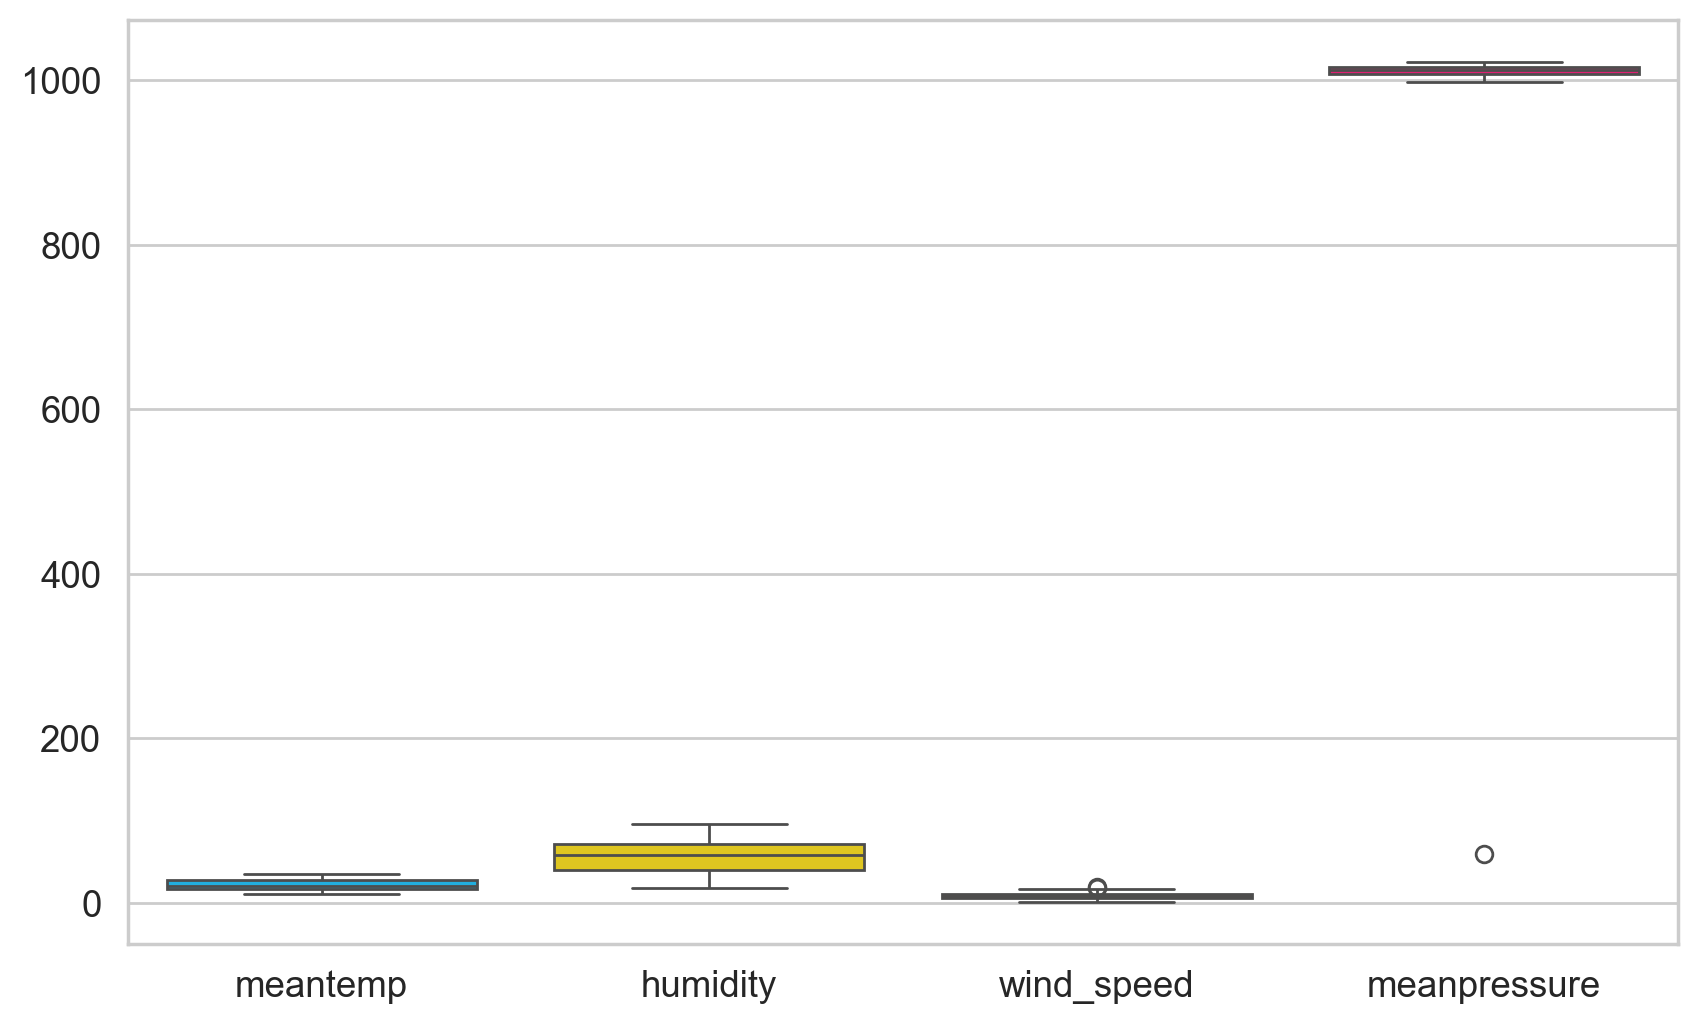

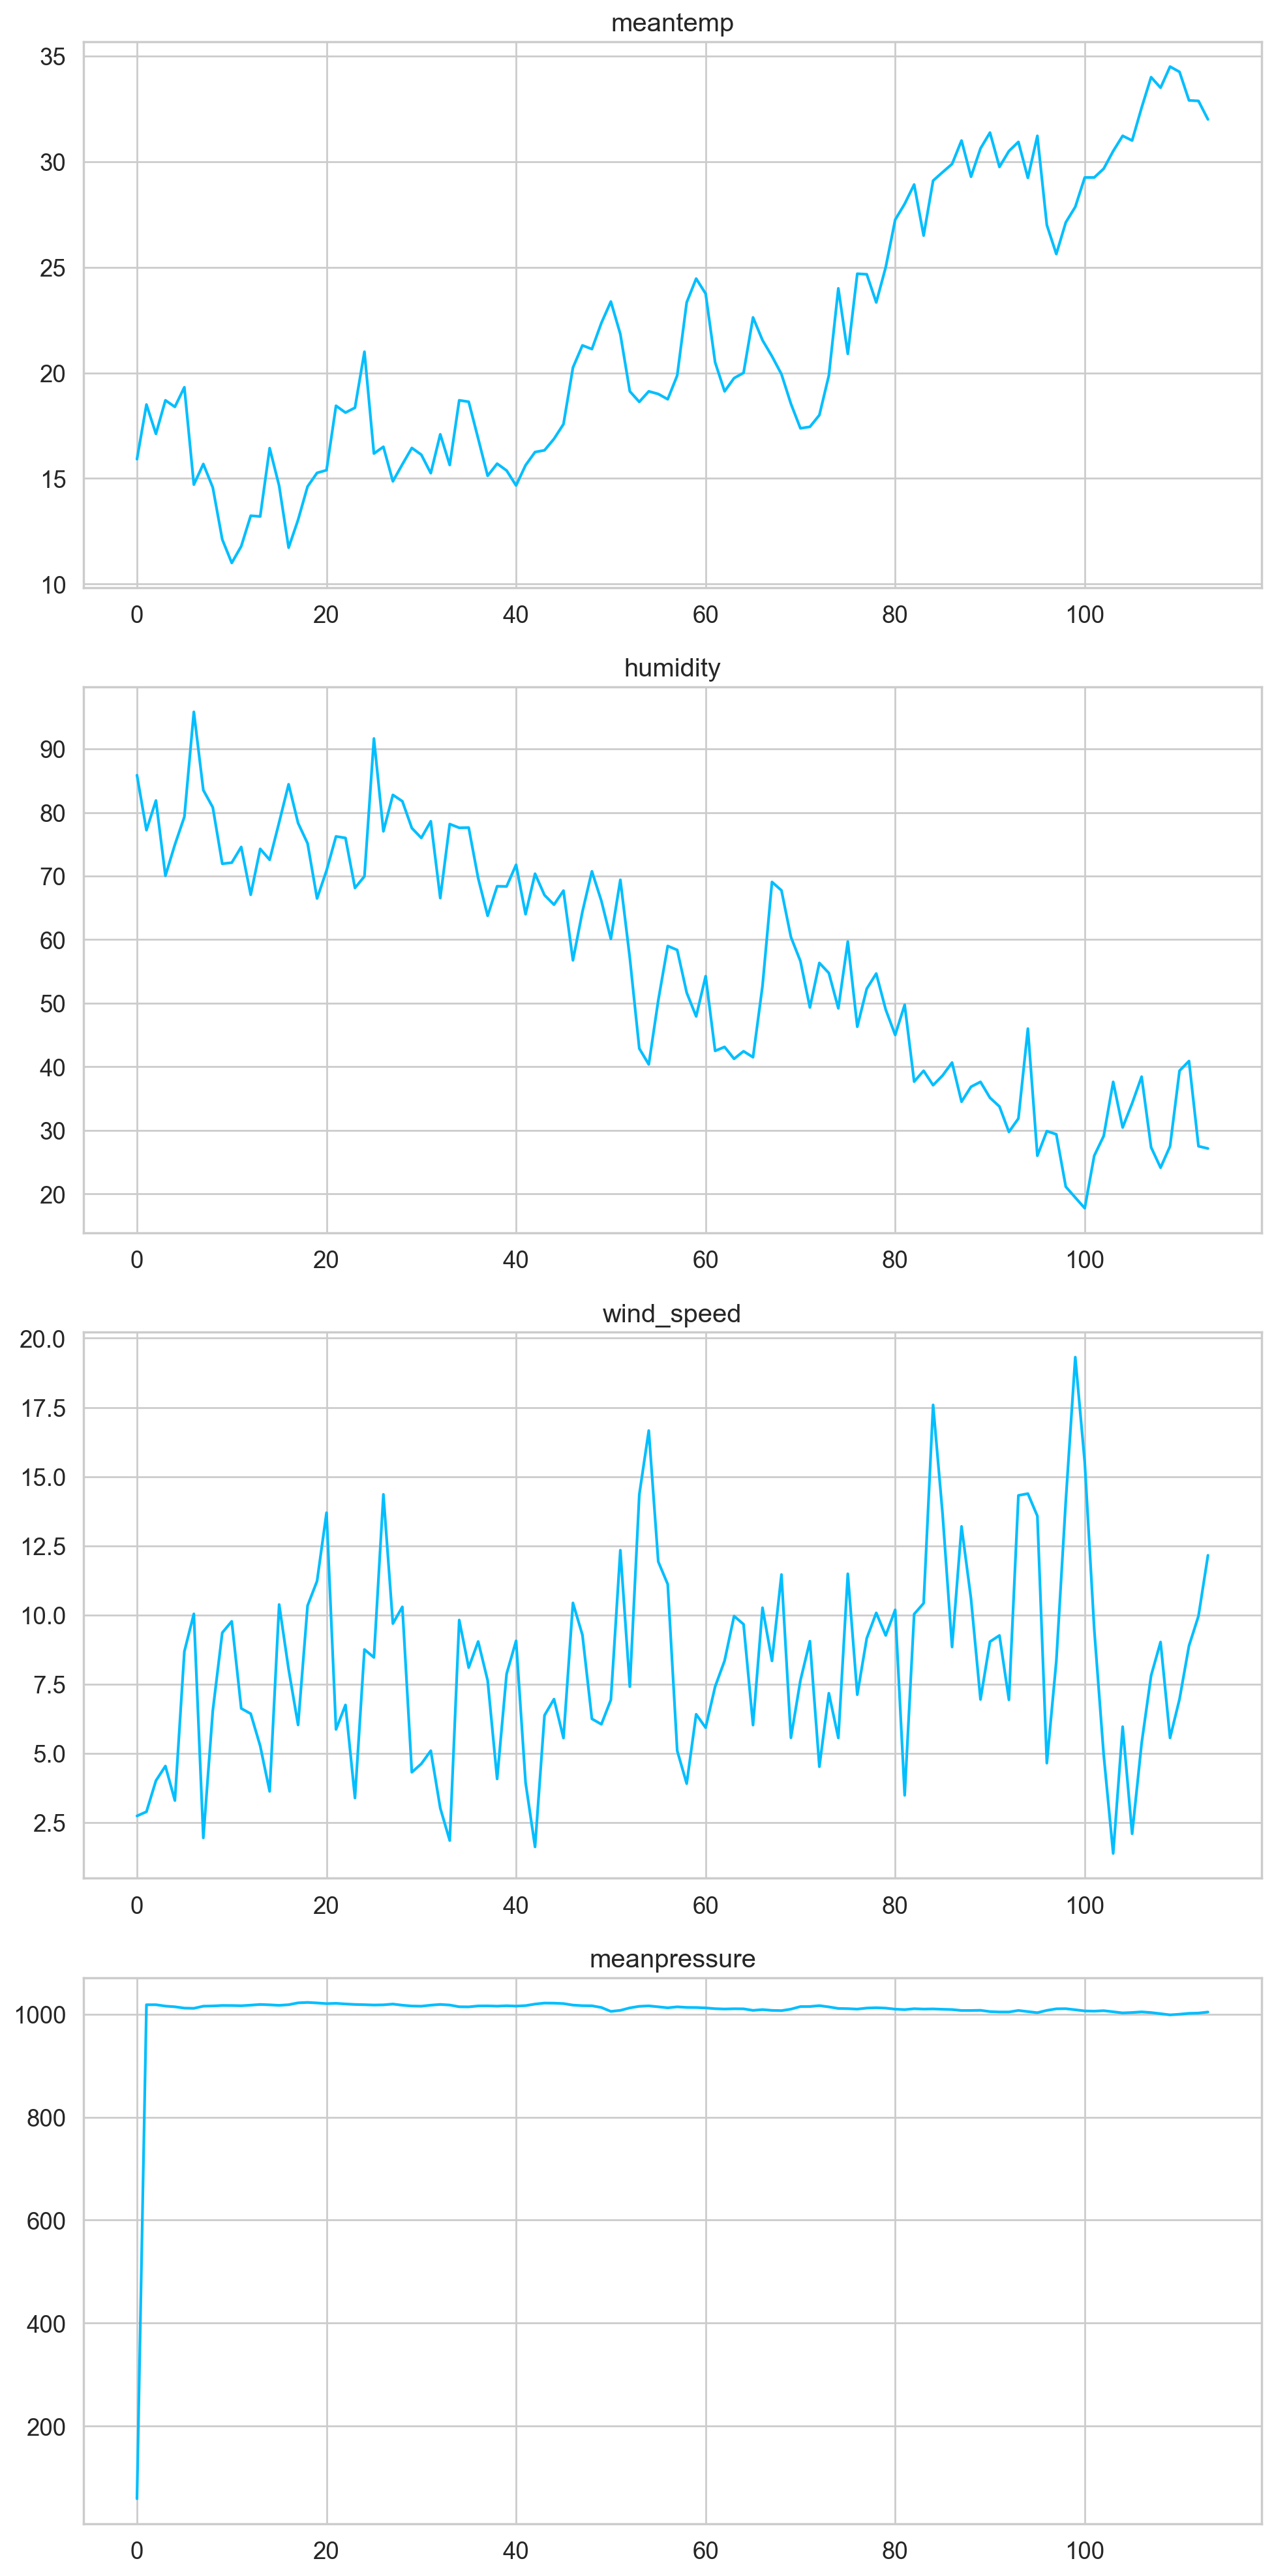

In [16]:
############################### view the train--validation data in plots #############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_new= df_test.copy()
print(df_new.shape)
# 可视化
plt.figure(figsize=(10, 6))
sns.boxplot(data= df_new)
print(list(df_new.columns))

# Number of rows and columns for the subplots
n_rows = 4
n_cols = 1

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 20))

# Loop through the columns and create a plot for each one
for i, col in enumerate(df_new.columns):
    axes[i].plot(df_new[col])
    axes[i].set_title(col)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# ######################## concat the train, validation and test dataframe together ###########################

print('df_new:', df_new.shape, len(df_new))
print('df_test_new:',  df_test_new.shape)

# df_concat_result = pd.concat([df_new, df_test_new], axis=0)
# print(df_concat_result.shape)

In [9]:
def modfy(inputs, sequence_length, which_columm):  ################# inputs: dataframe; sequence_length: step size; which used columm used as label #########################

                                # use 14 previous days to predict the next one
    df_numpy= inputs.values     #change DataFrame to Numpy 
    #scaler= StandardScaler()
    scaler= MinMaxScaler()      #set values up between 0 and 1

    df_numpy= scaler.fit_transform(df_numpy)
    print(df_numpy.shape)

    X, Y = [], []
    for i in range(len(df_numpy) - sequence_length):
        X.append(df_numpy[i:i+sequence_length])
        Y.append(df_numpy[i+sequence_length, which_columm])  # Predicting column"A"

    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    print('X, Y:', X.shape, Y.shape)
    return X, Y

In [ ]:
######################## modfy train data from 2d to 3d ######################
X, Y= modfy(df_new, 14, 0)

In [ ]:
################### split data for training and validation ###################################

X_train, X_val, y_train, y_val = train_test_split(X[:(1462- 28+ 1)], Y[: (1462- 28+ 1)], test_size=0.2, random_state=42)
print('X_train, X_valid, y_train, y_valid:', X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [ ]:
################## modfy test data ############################

X_test, y_test= modfy(df_test_new, 14, 0)
print('X_test, y_test:', X_test.shape, y_test.shape)

In [ ]:
################# Model Structure #####################

import torch.nn as nn

class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(TimeSeriesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)  # Predicting one value (column "A")

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.batch_norm(out[:, -1, :])
        out = self.dropout(out)
        #out = self.dropout(out[:, -1, :])  # Take the last time step
        out = self.fc(out)
        return out
    
#model = TimeSeriesLSTM(input_dim=7, hidden_dim=50, num_layers=2, dropout_prob=0.3)
model = TimeSeriesLSTM(input_dim= 4, hidden_dim= 32, num_layers= 3, dropout_prob=0.3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

print(model)

In [ ]:
############################ Training ###########################

In [ ]:

############################ random data split, minmax scaler, hidden_dim= 32, epochs 130, with Dropout 0.3, lr 0.001 #######################
epochs = 130
lr = 0.002
droprate= 0.3

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validate the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs.squeeze(), y_val)
    
    # Store the losses for plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training & Validation Loss(sklearn.random data split, minmax scaler, epochs {epochs}, lr {lr}, with Dropout {droprate})')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
################################# Var Model ###################################
import torch.nn as nn

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

class TimeSeriesLSTM_add_Var(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(TimeSeriesLSTM_add_Var, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)  # Predicting one value (column "A")

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.batch_norm(out[:, -1, :])
        out = self.dropout(out)
        #out = self.dropout(out[:, -1, :])  # Take the last time step
        out = self.fc(out)
        return out

    def evaluate_and_compute_variance(self, x):
        
        device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
        self.to(device)

        #self.eval()  # Set the model to evaluation mode
        #self.train()  # Set the model to train mode
        tensors_list = []

        num_iterations= 100
        for i in range(num_iterations):
            #outputs = self(X_val.to(device))
            outputs = self(x.to(device))
            # criterion = nn.MSELoss()
            # loss = criterion(outputs.squeeze(), y_val.to(device))
            # print(f"Loss at iteration {i}: {loss.item()}")
            tensors_list.append(outputs)

        # Stack the tensors to create a 3D tensor of size (num_iterations, 131, 1)
        stacked_tensors = torch.stack(tensors_list, dim=0)

        # Compute the variance along the first dimension
        variances = torch.var(stacked_tensors, dim=0, unbiased=False)

        variances_2d = variances.reshape(287, 1)
        return variances_2d
    
#model = TimeSeriesLSTM(input_dim=7, hidden_dim=50, num_layers=2, dropout_prob=0.3)
var_model = TimeSeriesLSTM_add_Var(input_dim= 4, hidden_dim= 32, num_layers= 3, dropout_prob=0.3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(var_model.parameters(), lr=0.001)

print(var_model)
    
# Assuming X_val and Y_val are your validation data tensors

############## have a try ##############################
variances_2d = var_model.evaluate_and_compute_variance(X_val)
print('variances_2d:', variances_2d.size())
print(variances_2d)

######################## Model save and load ###################################

In [ ]:
# torch.save(model.state_dict(), 'LSTM_weather_state_dict_14.pth')


In [ ]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")  
#套用模型，预测输出
loaded_model = TimeSeriesLSTM(input_dim= 4, hidden_dim= 32, num_layers= 3, dropout_prob=0.3).to(device)
model_weight_path = os.path.abspath(os.path.join(os.getcwd(),"/home/fe/twang/MA_copy/Uncertainty/SHAP_everything/codes/LSTM_weather_state_dict_14.pth"))
loaded_model.load_state_dict(torch.load(model_weight_path))

print(loaded_model)

################################ Verify #####################################

In [ ]:
##################################### Validation #############################
print(X_val.size(), y_val.size())

X_val = X_val.to(device)
y_val = y_val.to(device)
loaded_model = loaded_model.to(device)
print()

loaded_model.train()
#loaded_model.eval()
tensors_list= []
for i in range(100):
    
    outputs = loaded_model(X_val)
    print(outputs.size())
    print(outputs.squeeze().size())
    loss = criterion(outputs.squeeze(), y_val)
    print(f"Loss at iteration {i}: {loss.item()}")
    print()
    tensors_list.append(outputs)

# Stack the tensors to create a 3D tensor of size (100, 131, 1)
stacked_tensors = torch.stack(tensors_list, dim=0)

# Compute the variance along the first dimension
variances = torch.var(stacked_tensors, dim=0, unbiased=False)

variances_2d = variances.reshape(y_val.size(), 1)
print('variances_2d:', variances_2d.size())

In [ ]:
################################################### Test #######################################
print('X_test.size(), y_test.size():', X_test.size(), y_test.size())

X_test = X_test.to(device)
y_test = y_test.to(device)
loaded_model = loaded_model.to(device)
print()

tensors_list_test= []
loaded_model.train()
#loaded_model.eval()
for i in range(100):

    outputs = loaded_model(X_test)
    print(outputs.size())
    print(outputs.squeeze().size())
    loss = criterion(outputs.squeeze(), y_test)
    print(f"Loss at iteration {i}: {loss.item()}")
    print()
    tensors_list_test.append(outputs)

# Stack the tensors to create a 3D tensor of size (100, 131, 1)
stacked_tensors = torch.stack(tensors_list_test, dim=0)

# Compute the variance along the first dimension
variances_test = torch.var(stacked_tensors, dim=0, unbiased=False)

variances_test_2d = variances_test.reshape(y_test.size(), 1)
print('variances_2d:', variances_test_2d.size())

######################## Original SHAP #########################

In [ ]:
# Assuming `model` is your trained LSTM model in PyTorch
background = X_train[:800]  # or whatever subset you choose
#background= background.to(device)
print('background:', type(background),background.size())
print()
#loaded_model.train()
#var_model.train()
loaded_model.train()
print(type(loaded_model))
print()

#如果问题持续存在，作为一种可能的解决方案，可以尝试不使用 CuDNN 优化的 RNN。这可以通过在模型初始化前设置 torch.backends.cudnn.enabled = False 来实现，但请注意这可能会影响模型的性能。
torch.backends.cudnn.enabled = False
#######################################      Kernel_Explainer  #############################################
#explainer= shap.KernelExplainer(model, x_train_std.to_numpy().astype(np.float32)) # x is DataFrame here

#######################################      Deep_Explainer    #############################################
#explainer= shap.DeepExplainer(var_model, background.to(device))
explainer= shap.DeepExplainer(loaded_model, background.to(device))

############################# SHAP which data ############################
#shap_values = explainer.shap_values(X_test)
shap_values = explainer.shap_values(X_test)
print('X_test:', X_test.shape)
#Val_variances_2d
print('############')
print('shap_values:', type(shap_values), shap_values.shape)
print('explainer.expected_value:', explainer.expected_value.shape, explainer.expected_value)